# Plotting PyPSA results (simplified version 4-nodes clustering and 1 year data - Bolivia)

In [1]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  c:\Users\Lenovo\Desktop\pypsa-earth
Had to go 1 folder(s) up.


In [2]:
# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [3]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# n_add_el = pypsa.Network(add_electricity_network)

# clustered_network = os.getcwd() + '/networks/elec_s_20.nc'
# n_cluster = pypsa.Network(clustered_network)



#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

solved_network = os.getcwd() + "/results/networks/elec_s_4_ec_lcopt_Co2L-4H.nc"

base_network= os.getcwd() +  "/networks/base.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_base= pypsa.Network(base_network)

n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers
INFO:pypsa.io:Imported network elec_s_4_ec_lcopt_Co2L-4H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


# Base network

In [4]:
n_base

PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 104
 - Line: 88
 - Transformer: 22
Snapshots: 8760

(<matplotlib.collections.PatchCollection at 0x2767507aec0>,
 <matplotlib.collections.LineCollection at 0x2767518d150>)

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


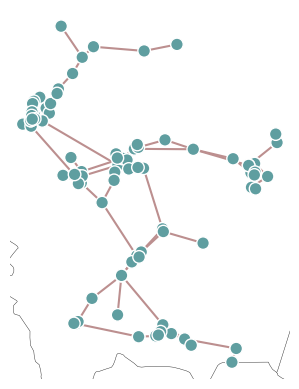

In [5]:
n_base.plot()

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


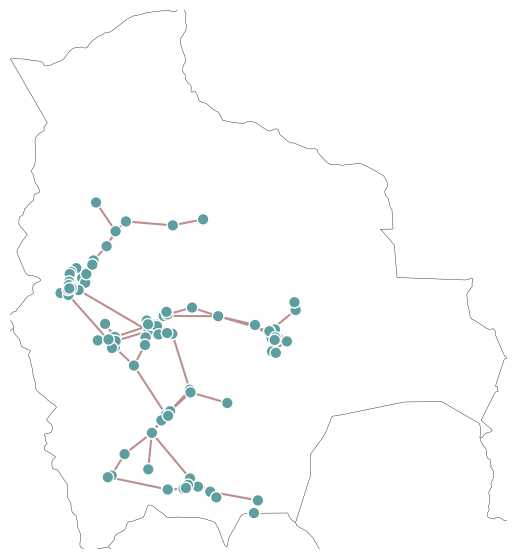

In [35]:
import matplotlib.pyplot as plt
import pypsa
import numpy as np
import cartopy.crs as ccrs

#countries = ["Bolivia"]

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

n_base.plot(ax=ax)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


# Solved network

In [36]:
n = n_solve
n

PyPSA Network
Components:
 - Bus: 15
 - Carrier: 16
 - Generator: 29
 - GlobalConstraint: 1
 - Line: 4
 - Link: 20
 - Load: 5
 - Store: 10
Snapshots: 2190

In [37]:
# ".global_constraints" muestra las restricciones consideradas para el modelo (en el config.yaml solo se tomo en cuenta el limite de emisiones) tonCO2/year

n.global_constraints

,sense,constant,mu,type,investment_period,carrier_attribute
GlobalConstraint,,,,,,
CO2Limit,<=,77500000.0,3.059076e-12,primary_energy,NaN,co2_emissions


In [38]:
#Calculo del precio promedio de energia promedio en la red (costo total de operacion)= ".objective" /  (sumatoria de las cargas variables en el tiempo)
# EURO/MWh

##### check why the value does not appear 
#   - It seems that while the model run before, due to restrictions on simulation, proper solving wasn't possible (by increasing tolerances of the solver the model gets actual results)


n.objective

192693988.47319898

### Spatial temporal resolution

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


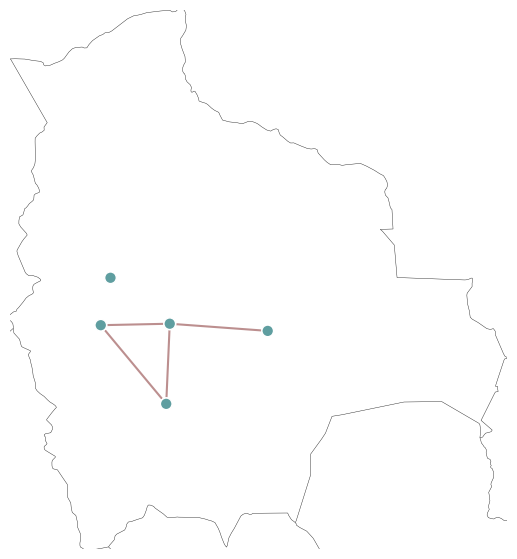

In [39]:
#Resultado grafico de la red electrica ideal (lineas verdes representan expansiones de la red)

#####beacuase all buses are not connected it might be that the problem is not fully solved 
# - Lines used in the model don't consider newer power lines (data bases were not apdated)
# - This is proved by comparing raw lines (all available lines in OSM) and clean lines (processed lines to be used in the model)
# - A linker is required to include new/additional data into the "all_clean_lines.geojson"

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

n.plot(ax=ax)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


In [11]:
#Se muestra el tamaño de la resolucion temporal del modelo - timesteps 
# - Currently the system is working with a toy version of Bolivia to allow faster solving times (4h time aggregation and a little over 5 months acoording the rules in the config.yaml file) 
# - A more complete model should be run eventually with different conditions (higher time resolution) or methods like tsam (https://tsam.readthedocs.io/en/latest/mathematicalBackgroundDoc.html)
#  

len(n.snapshots)

2190

### Overview components

In [40]:
#Imprimir la lista de componentes considerados en el dataframe creado

for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 15 entries
Component 'Carrier' has 16 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 4 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 20 entries
Component 'Load' has 5 entries
Component 'Generator' has 29 entries
Component 'Store' has 10 entries


### Energy balance

In [41]:
# ".stores_t" hace referencia a la energia que se puede almacenar en un bus (se usa para definir otras tecnologias como storage)
# - https://pypsa.readthedocs.io/en/latest/components.html#store

n.stores_t.p.sum()

Store
BO0 0 H2         0.000000e+00
BO0 1 H2         0.000000e+00
BO0 2 H2         0.000000e+00
BO0 3 H2         0.000000e+00
BO1 0 H2        -5.684342e-14
BO0 0 battery   -5.082198e-20
BO0 1 battery    8.470329e-21
BO0 2 battery   -1.524659e-20
BO0 3 battery    1.355253e-20
BO1 0 battery   -3.410605e-13
dtype: float64

In [42]:
# se imprimen todos los generadores considerados en el modelo

##### check if loadshedding is being used in the config.yaml file, at the solving section 
# - load shedding is represented in the model by the inclution on additional "load" generation/generators 

n.generators

print(type(n.generators))
print(n.generators.columns)
n.generators.head()

<class 'pandas.core.frame.DataFrame'>
Index(['p_nom_max', 'weight', 'p_nom', 'capital_cost', 'efficiency',
       'p_nom_min', 'marginal_cost', 'carrier', 'p_nom_extendable', 'bus',
       'max_hours', 'efficiency_dispatch', 'efficiency_store',
       'cyclic_state_of_charge', 'control', 'p_nom_opt', 'sign', 'build_year',
       'min_up_time', 'min_down_time', 'up_time_before', 'down_time_before',
       'type', 'p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'lifetime',
       'committable', 'start_up_cost', 'shut_down_cost', 'ramp_limit_up',
       'ramp_limit_down', 'ramp_limit_start_up', 'ramp_limit_shut_down'],
      dtype='object')


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,carrier,p_nom_extendable,bus,max_hours,efficiency_dispatch,efficiency_store,cyclic_state_of_charge,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO0 0 OCGT,inf,0.000000,49.250000,47234.561404,0.39,49.250000,58.395132,OCGT,True,BO0 0,NaN,NaN,NaN,NaN,Slack,49.250000,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 0 hydro,inf,0.000000,170.360000,0.000000,1.00,0.000000,0.009784,hydro,False,BO0 0,NaN,NaN,NaN,NaN,,170.360000,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 0 onwind,2.368176e+05,9873.010643,1.285077,109295.569252,1.00,1.285077,0.025899,onwind,True,BO0 0,NaN,NaN,NaN,NaN,,1.285077,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 0 solar,3.289729e+05,66801.767430,24.010108,50855.958267,1.00,24.010108,0.020064,solar,True,BO0 0,NaN,NaN,NaN,NaN,,780.952102,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 1 CCGT,inf,0.000000,396.770000,84469.122809,0.50,396.770000,47.209056,CCGT,True,BO0 1,NaN,NaN,NaN,NaN,,396.770001,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [43]:
#Imprimir solo los generadores de Bolivia

########this is only necessary if several countries are studied at the same time

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:].head()

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,carrier,p_nom_extendable,bus,max_hours,efficiency_dispatch,efficiency_store,cyclic_state_of_charge,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO0 0 OCGT,inf,0.000000,49.250000,47234.561404,0.39,49.250000,58.395132,OCGT,True,BO0 0,NaN,NaN,NaN,NaN,Slack,49.250000,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 0 hydro,inf,0.000000,170.360000,0.000000,1.00,0.000000,0.009784,hydro,False,BO0 0,NaN,NaN,NaN,NaN,,170.360000,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 0 onwind,2.368176e+05,9873.010643,1.285077,109295.569252,1.00,1.285077,0.025899,onwind,True,BO0 0,NaN,NaN,NaN,NaN,,1.285077,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 0 solar,3.289729e+05,66801.767430,24.010108,50855.958267,1.00,24.010108,0.020064,solar,True,BO0 0,NaN,NaN,NaN,NaN,,780.952102,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO0 1 CCGT,inf,0.000000,396.770000,84469.122809,0.50,396.770000,47.209056,CCGT,True,BO0 1,NaN,NaN,NaN,NaN,,396.770001,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [44]:
#Imprimir la suma de potencias nominales (2013) de los generadores de Bolivia

####### Data was not yet updated and therefore a big difference between real capacities in 2020 (largely oversized) and optimized installed capacities (relatively low changes)
# - To change this, additional plants have to be added to better represent the system

idx = ['BO' in x for x in n.generators.index]

print(n.generators.loc[idx,:].p_nom.sum())
print(n.generators.loc[idx,:].p_nom_opt.sum())

5000003234.91887
5000004656.29929


In [45]:
# Difference between total load and generation
# losses = n.stores_t

n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses


966084.8065936277

### Total installed generator capacity

In [46]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap.to_csv('capacities_by_carrier.csv',index=False)
gen_cap


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2324\3296247162.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,max_hours,efficiency_dispatch,efficiency_store,cyclic_state_of_charge,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCGT,NaN,0.000000,1.029050e+03,253407.368427,1.500,1029.050000,141.630204,3,0.0,0.0,0.0,0.0,1.029050e+03,3.000,0,0,0,3,0,0.0,3.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,3.0,3.0
OCGT,NaN,0.000000,1.239830e+03,188938.245618,1.560,1239.830000,233.578256,4,0.0,0.0,0.0,0.0,1.239830e+03,4.000,0,0,0,4,0,0.0,4.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,4.0,4.0
biomass,NaN,0.000000,7.723000e+01,556030.719012,0.936,77.230000,29.934074,0,0.0,0.0,0.0,0.0,7.723000e+01,2.000,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
hydro,NaN,0.000000,7.322000e+02,0.000000,4.000,0.000000,0.039714,0,0.0,0.0,0.0,0.0,7.322000e+02,4.000,0,0,0,4,0,0.0,4.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,4.0,4.0
load,NaN,0.000000,5.000000e+09,0.000000,5.000,0.000000,5.049812,0,0.0,0.0,0.0,0.0,5.000000e+09,0.005,0,0,0,5,0,0.0,5.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,5.0,5.0
oil,inf,0.000000,1.174000e+01,38234.561404,0.393,11.740000,130.236015,0,0.0,0.0,0.0,0.0,1.174000e+01,1.000,0,0,0,1,0,0.0,1.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
onwind,2.371526e+06,160226.734509,2.591088e+01,546477.846258,5.000,25.910879,0.126867,5,0.0,0.0,0.0,0.0,2.591088e+01,5.000,0,0,0,5,0,0.0,5.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,5.0,5.0
solar,1.862944e+06,329520.899006,1.189580e+02,254279.791335,5.000,118.957991,0.100815,5,0.0,0.0,0.0,0.0,1.540338e+03,5.000,0,0,0,5,0,0.0,5.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,5.0,5.0


In [47]:
n.stores_t.p.head()

Store,BO0 0 H2,BO0 1 H2,BO0 2 H2,BO0 3 H2,BO1 0 H2,BO0 0 battery,BO0 1 battery,BO0 2 battery,BO0 3 battery,BO1 0 battery
snapshot,,,,,,,,,,
2013-01-01 00:00:00,5.594119e-07,5.814315e-07,5.696465e-07,5.883556e-07,0.725875,-3.289533e-07,-2.676240e-07,-2.807499e-07,-2.444823e-07,96.653515
2013-01-01 04:00:00,6.341743e-07,6.591686e-07,6.220071e-07,6.794098e-07,0.693514,2.795872e-07,3.360460e-07,2.673646e-07,3.742655e-07,6.057539
2013-01-01 08:00:00,6.316708e-07,6.535453e-07,6.225879e-07,7.059754e-07,0.748538,6.127297e-07,6.910669e-07,6.453128e-07,7.711832e-07,28.473870
2013-01-01 12:00:00,7.379105e-07,7.221304e-07,7.191138e-07,7.199758e-07,-58.675208,4.435121e-06,4.393333e-06,4.441898e-06,4.312742e-06,-38.037360
2013-01-01 16:00:00,-7.804683e-06,-7.935573e-06,-7.881316e-06,-8.062818e-06,-58.675208,-1.053737e-05,-1.069391e-05,-1.061771e-05,-1.076690e-05,-102.054488


<AxesSubplot:xlabel='snapshot'>

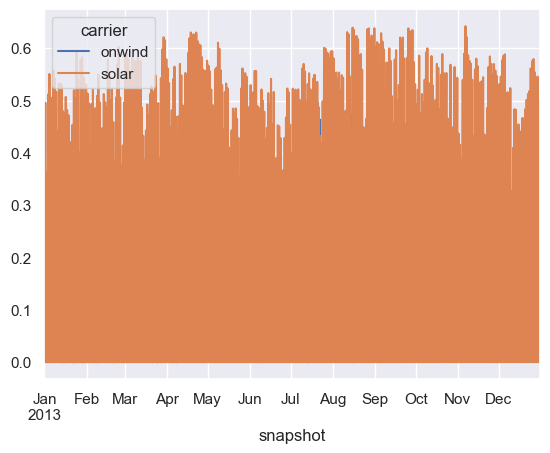

In [48]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [49]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [50]:
n.loads_t.p.sum().sum()

2827084.0334878056

In [51]:
n.generators_t.p.sum().sum()

3793168.8400814333

In [52]:
#### pq la multiplicacion?

n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom.sum() * 0.0000003

bus    carrier
BO0 0  OCGT       1.477500e-05
       hydro      5.110800e-05
       load       3.000000e+02
       onwind     3.855232e-07
       solar      7.203032e-06
BO0 1  CCGT       1.190310e-04
       OCGT       1.476150e-04
       hydro      8.377500e-05
       load       3.000000e+02
       onwind     1.395710e-07
       solar      1.244267e-06
BO0 2  CCGT       7.449000e-05
       OCGT       6.014100e-05
       hydro      7.950000e-06
       load       3.000000e+02
       onwind     2.354398e-06
       solar      1.715770e-05
BO0 3  CCGT       1.151940e-04
       OCGT       1.494180e-04
       biomass    2.168700e-05
       load       3.000000e+02
       onwind     3.333886e-06
       solar      3.331862e-06
BO1 0  biomass    1.482000e-06
       hydro      7.682700e-05
       load       3.000000e+02
       oil        3.522000e-06
       onwind     1.559886e-06
       solar      6.750535e-06
Name: p_nom, dtype: float64

### Demand

In [25]:
print(type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()))

print(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

<class 'pandas.core.series.Series'>
bus
BO0 0    1.000001e+09
BO0 1    1.000001e+09
BO0 2    1.000001e+09
BO0 3    1.000001e+09
BO1 0    1.000001e+09
Name: p_nom_opt, dtype: float64


<AxesSubplot:xlabel='snapshot'>

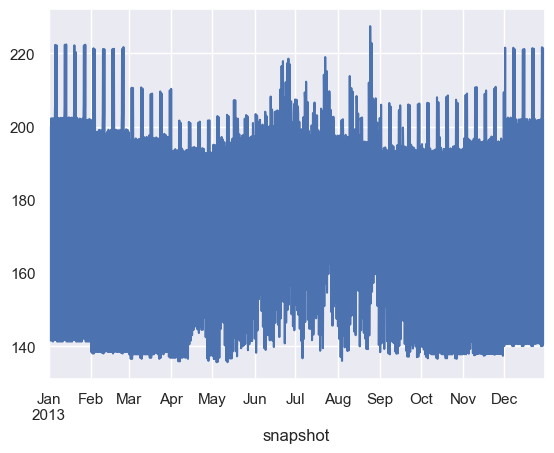

In [53]:
n.loads_t.p_set.loc["2013-01-01":"2013-12-30","BO0 0"].plot()

Load
BO0 0    390389.637563
BO0 1    335512.126430
BO0 2    777323.575142
BO0 3    585486.801029
BO1 0    738371.893324
dtype: float64


<AxesSubplot:xlabel='Load'>

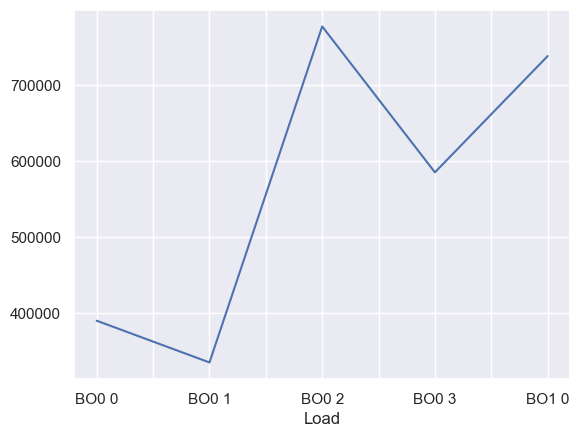

In [54]:
print(n.loads_t.p_set.sum())

n.loads_t.p_set.sum().plot()

In [28]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
BO0 0    390389.637563
BO0 1    335512.126430
BO0 2    777323.575142
BO0 3    585486.801029
BO1 0    738371.893324
Name: load, dtype: float64

In [29]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

###### potencia maxima?
#n.generators.iloc[:, :].groupby(["bus"]).p_max_pu.sum()

bus
BO0 0    1.000001e+09
BO0 1    1.000001e+09
BO0 2    1.000001e+09
BO0 3    1.000001e+09
BO1 0    1.000001e+09
Name: p_nom_opt, dtype: float64

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


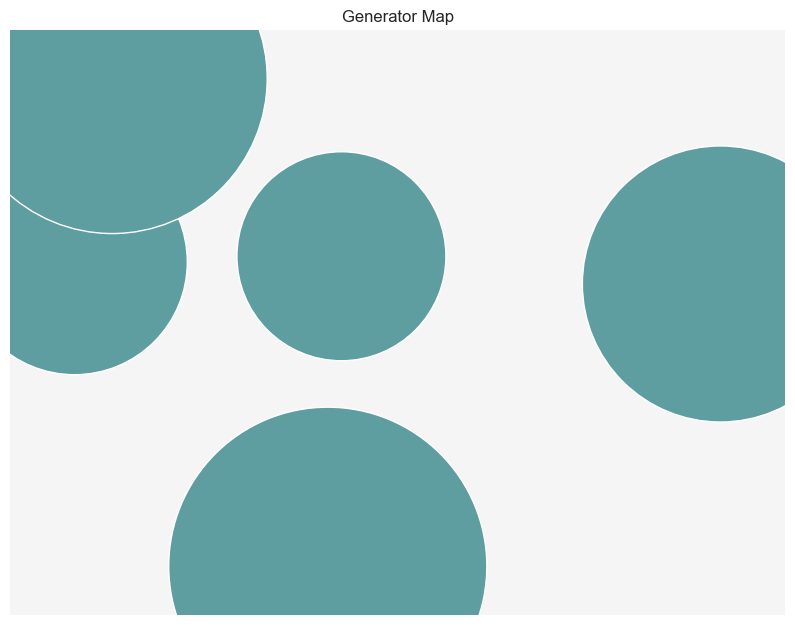

In [30]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3000000000e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

In [55]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus    carrier
BO0 0  OCGT       4.925000e+01
       hydro      1.703600e+02
       load       1.000000e+09
       onwind     1.285077e+00
       solar      7.809521e+02
BO0 1  CCGT       3.967700e+02
       OCGT       4.920500e+02
       hydro      2.792500e+02
       load       1.000000e+09
       onwind     4.652371e-01
       solar      4.147558e+00
BO0 2  CCGT       2.483000e+02
       OCGT       2.004700e+02
       hydro      2.650000e+01
       load       1.000000e+09
       onwind     7.847992e+00
       solar      5.719234e+01
BO0 3  CCGT       3.839800e+02
       OCGT       4.980600e+02
       biomass    7.229000e+01
       load       1.000000e+09
       onwind     1.111295e+01
       solar      1.110621e+01
BO1 0  biomass    4.940000e+00
       hydro      2.560900e+02
       load       1.000000e+09
       oil        1.174000e+01
       onwind     5.199621e+00
       solar      6.869402e+02
BO0 0  AC load    3.903896e+05
BO0 1  AC load    3.355121e+05
BO0 2  AC load    7.7732

### Plot of Average Marginal Price

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


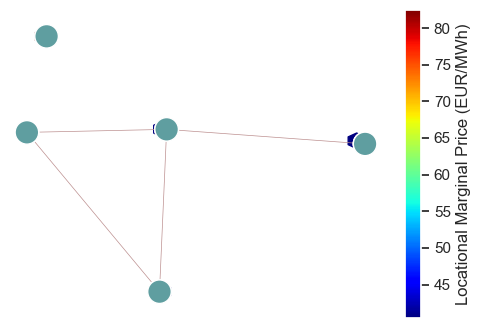

In [32]:
now = n.snapshots[4]  ##one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(6, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot:xlabel='snapshot'>

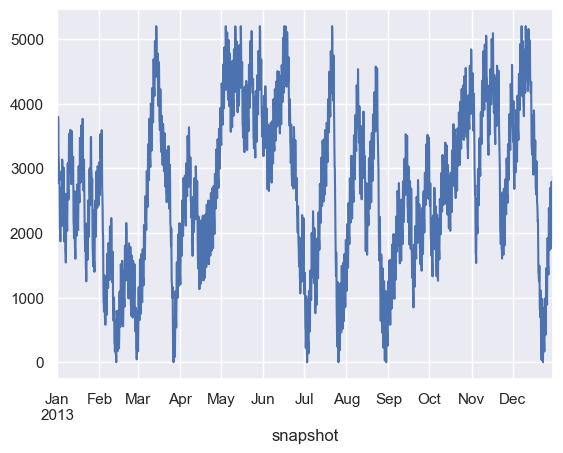

In [56]:
n.stores_t.e.loc["2013-01-01":"2013-12-30"].sum(axis=1).plot()

In [34]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
H2 electrolysis        73.344068
H2 fuel cell           65.645196
battery charger       115.679806
battery discharger    128.533117
Name: p_nom_opt, dtype: float64

# Trying out other plots

#Authored by F.Hofmann

#The notebook reproduces the plot like a beautiful scheme of the European Transmission System published in https://arxiv.org/abs/1806.01613.

In [57]:
import pypsa
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

In [61]:
country_code = "bo"
n = pypsa.Network(r"C:\Users\Lenovo\Desktop\pypsa-earth\networks\elec.nc")
regions_onshore = gpd.read_file(r"C:\Users\Lenovo\Desktop\pypsa-earth\resources\shapes\country_shapes.geojson")

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, transformers


In [80]:
bus_scale = 4e3 
line_scale = 5e2

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


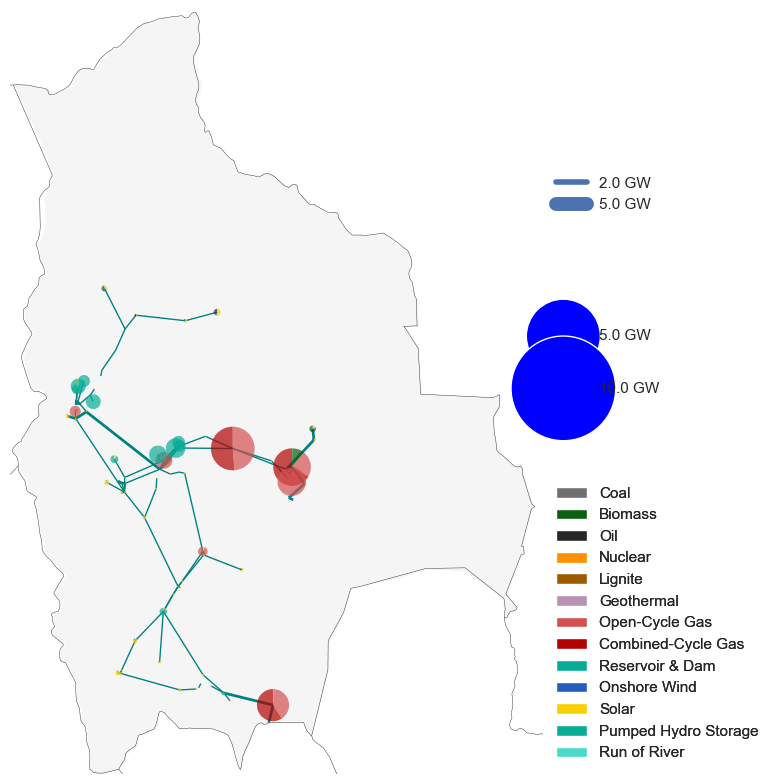

In [81]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators.groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom / line_scale,
        link_widths=n.links.p_nom / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
# circles legend may requite some fine-tuning
legend_circles_dict = {"bbox_to_anchor": (1, 0.6), "labelspacing": 2.5, **legend_kwargs}
bus_sizes = [5000, 10e3]  # in MW
line_sizes = [2000, 5000]  # in MW
add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()
fig.savefig("brownfield_capacities_" + country_code + ".png", bbox_inches="tight", dpi=300)